First we're going to import some libraries:
- numpy for matrix calculations;
- tensorflow for getting the fashion MNIST dataset;
- matplotlib.pyplot for data visualisation.

Then we're going to get our data and normalise it. \
Then we're going to split it into train, validation and test sets. \
The fashion MNIST have pixel values from 0 to 255, and these need to be adjusted to be from 0 to 1.

In [2]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt

# Getting our data in the way we're given it; only time we use tensorflow
import tensorflow as tf 
(X, y), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Seeing the shape of the data to see how it should be partitioned into train,
#   validation and test sets.
print("X shape", X.shape)
print("y shape", y.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

4422102/4422102 [==============================] - 1s 0us/step
X shape (60000, 28, 28)
y shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


In [3]:
# Get the number of examples in X
N = X.shape[0]

# Declare the number of training examples and validation examples you want
num_val = 10000
num_train = N - num_val

# Normalise the data by taking away the mean
mu = np.mean(X, axis =0)
sd = np.std(X, axis=0)
X = (X- mu)/(sd + 1e-7) # Normalised
#X = X/255
y = y*1
X_test = (X_test - np.mean(X_test, axis = 0))/(np.std(X_test, axis = 0) + 1e-7) # Normalised
#X_test = X_test/255
y_test = y_test*1

# Get the training set as a random selection from the set X
mask = np.random.choice(N, num_train + num_val, replace=False)
X_train = X[mask[:num_train]]
y_train = y[mask[:num_train]]
X_val = X[mask[num_train:]]
y_val = y[mask[num_train:]]

# Data Visualisation
Note that in the above cell, I normalise the images, so the following images look a bit ghostly.

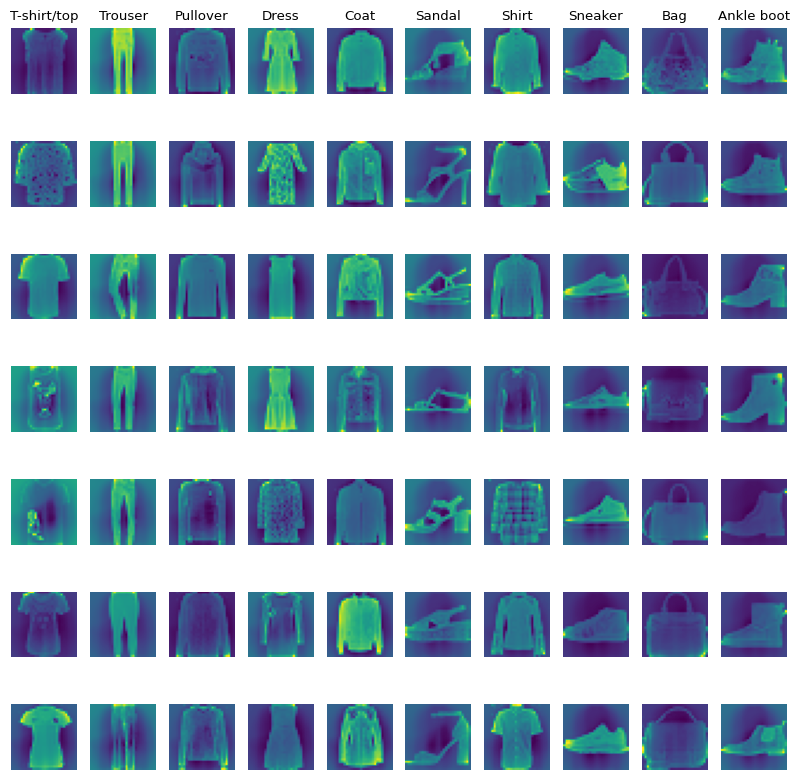

In [4]:
# Get labels for all the examples, according to y_test output
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

plt.rcParams.update({'font.size': 8}) # Set font size.
plt.figure(figsize=(10,10)) # Set figure size

# Print the images
num_classes = len(classes)
samples_per_class = 7
for t, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == t)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + t + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Ankle boot


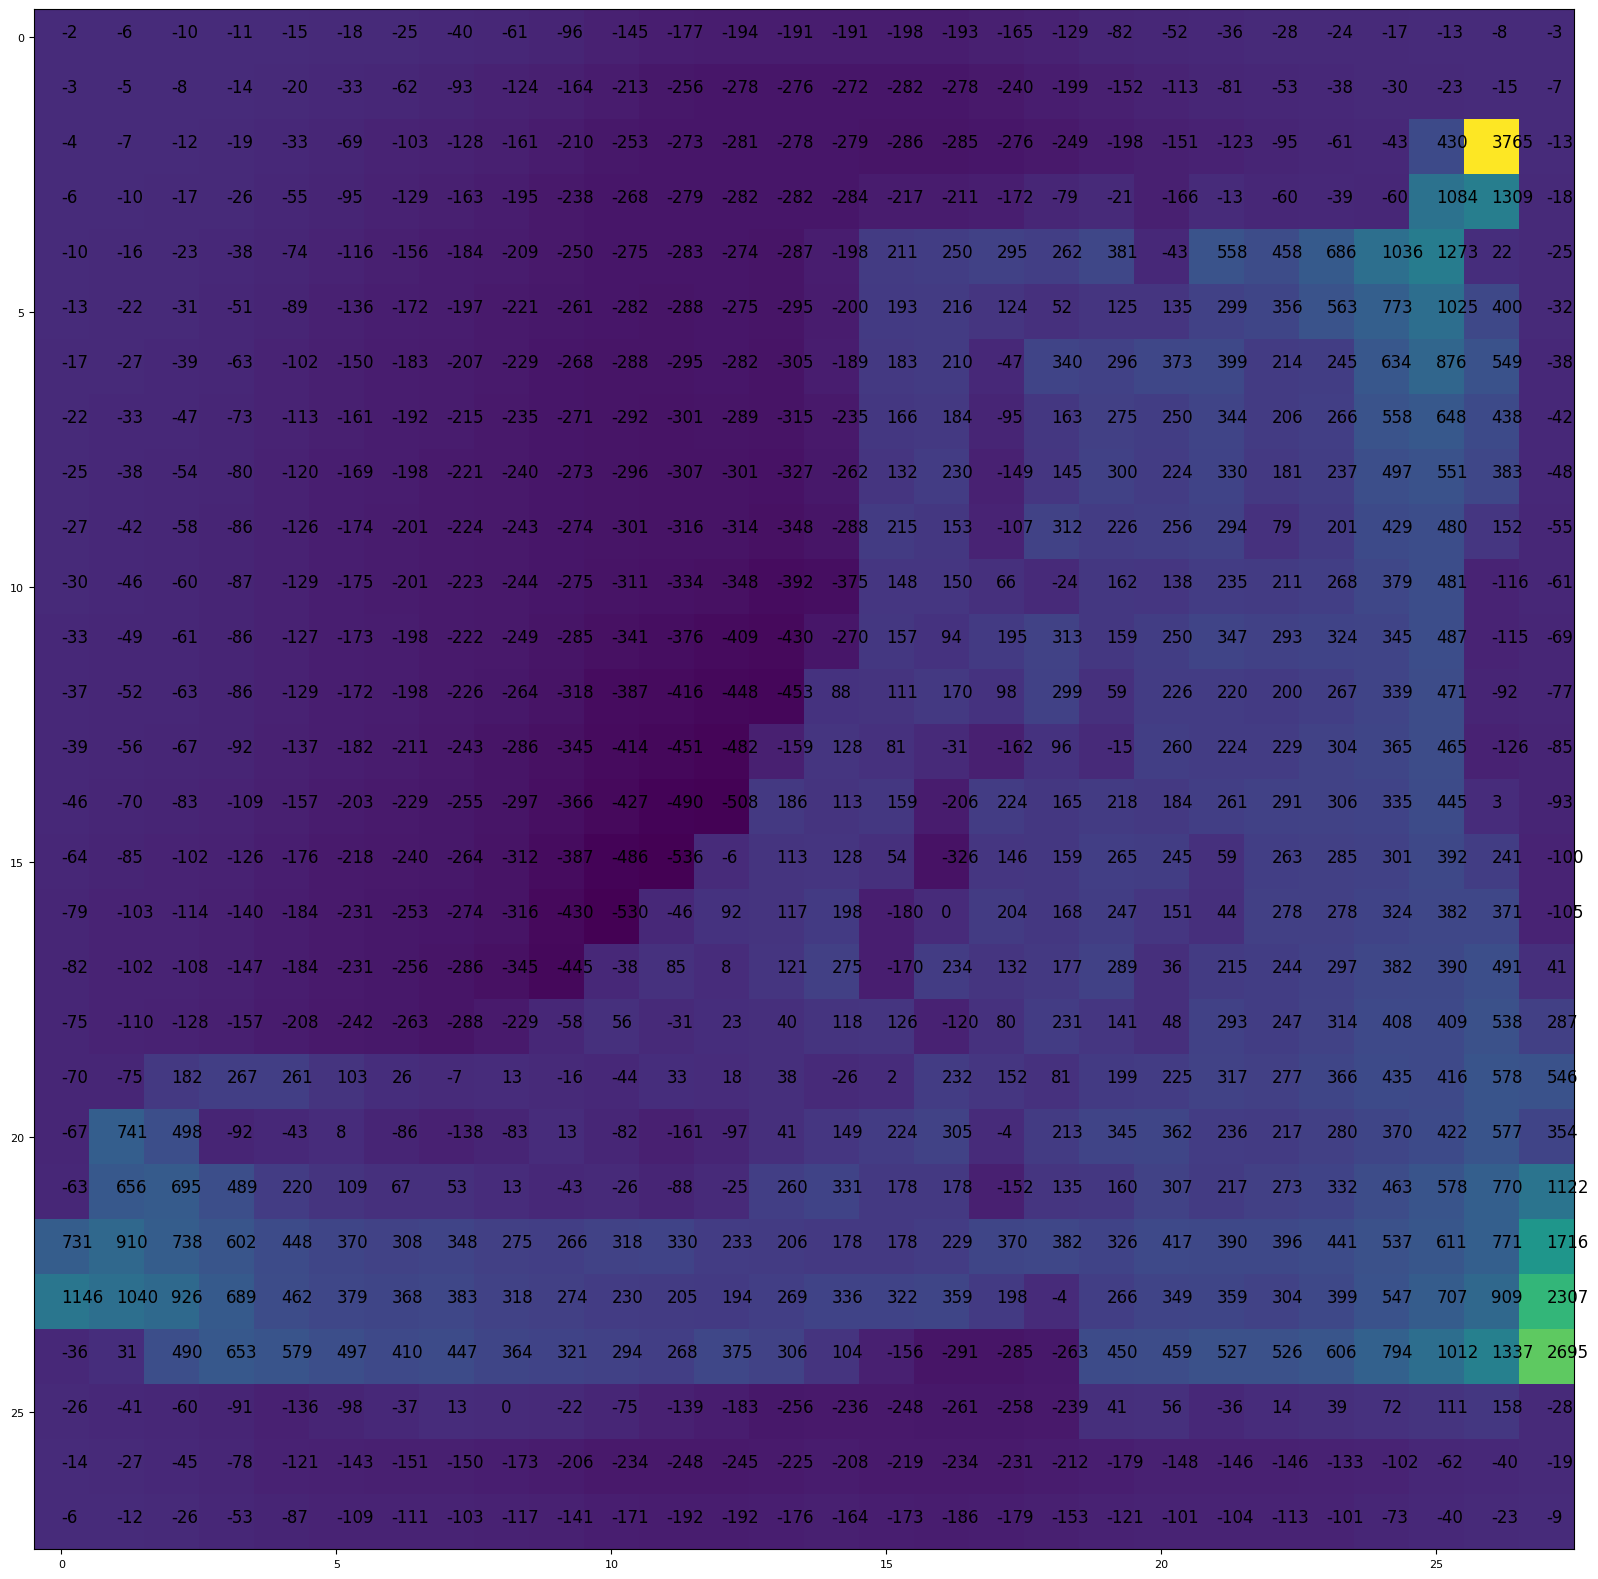

In [5]:
# Get a random image and it's values (print values in latex)
index = np.random.choice(num_train)
image = X_train[index]
num_rows = len(image)
num_cols = len(image[0])

fig, ax = plt.subplots(figsize= (20,20))
for i, row in enumerate(image):
    for j, element in enumerate(row):
        if element == 0.00:
            ax.text(j, i, 0, size=18)
        else:
            ax.text(j, i, "{:.0f}".format(element*255), size=12)
plt.imshow(image)
print(classes[y_train[index]])
plt.show()



From above, you can see that shirts, coats, and pullovers look very similar, as do ankle boots and sneakers. We may do some testing later to see if the model indeed finds it hard to label these correctly. 

In [6]:
# Import my neural network module.
import network
from network import NeuralNetwork

# Reload the import bc ipynb doesn't update changes to network.py.
# only after it's run once, if it's stuck
import importlib
importlib.reload(network)

# Set the parameters for the layers
dims = (784, 250, 50, 10)
afs = ("r", "r", "sm")
model = NeuralNetwork(dims, afs)

In [10]:
# Final Training and Testing ~
# Reset the model.
model.reset()

# 5000*5 + 1000
# Get trainging data.
data = {}
data["X"] = X_train.reshape(X_train.shape[0], 784)
data["y"] = y_train

# Get testing data.
data_test = {}
data_test["X"] = X_test.reshape(X_test.shape[0], 784)
data_test["y"] = y_test

# Set up learning rate and learning rate decay
learning_rate = 3.38e-3
lr_decay = 0.56

# Train the model
loss_hist = model.train(
    data        = data, 
    num_epoch   = 10, 
    lr          = learning_rate, 
    lr_decay    = lr_decay, 
    verbose     = True,
    decay_rate  = "every epoch"
    )

# Get the accuracy
accuracy = model.checkAccuracy(data = data_test)

# Print accuracy
print("Accuracy: ", accuracy)

Epoch:  1
Epoch:  1
decayed
Epoch:  2
Epoch:  2
decayed
Epoch:  3
Epoch:  3
decayed
Epoch:  4
Epoch:  4
decayed
Epoch:  5
Epoch:  5
decayed
Epoch:  6
Epoch:  6
decayed
Epoch:  7
Epoch:  7
decayed
Epoch:  8
Epoch:  8
decayed
Epoch:  9
Epoch:  9
decayed
Epoch:  10
Epoch:  10
decayed
Accuracy:  0.8856


# Hyper-parameter Tuning
This part was used to tune the learning rate and decay for my model., It can be safely ignored. \
I've changed it a lot manually depending on which hyperparams worked and which did not, so it does not make much sense on its own.

In [ ]:
""" HYPERPARAMETER TUNING, CAN SAFELY IGNORE """
# ~27 min run
# Train the Network and check validation accuracy for multiple learning rates and decays.

# Get the training size fraction
tsf_train = 5000
tsf_val = 1000

# Get a mask of random indexes for X_train, y_train, X_val and y_val.
train_mask = np.random.choice(num_train, tsf_train)
val_mask = np.random.choice(num_val, tsf_val)

# 5000*5 + 1000 takes about 3 minutes
# Get trainging data.
data = {}
data["X"] = X_train.reshape(X_train.shape[0], 784)[train_mask]
data["y"] = y_train[train_mask]

# Get validation data.
data_val = {}
data_val["X"] = X_val.reshape(X_val.shape[0], -1)[val_mask]
data_val["y"] = y_val[val_mask]

# Clear the model to retrain
model.reset()

# Initialise learning rate decay
lr_decays = np.linspace(0.01,1,10)

# Make a vector of learning rates,  trained on lr_decay 0.25
learning_rate = 3.4e-3

# Make a history of accuracies for each learning rate
accuracies = []

# Seach over your learning rates vector to find the best learning rate
for count, lr_decay in enumerate(lr_decays):
    print("learning rate number", count)

    # Clear the model to retrain
    model.reset()

    # Train the model
    loss_hist = model.train(
        data        = data, 
        num_epoch   = 5, 
        lr          = learning_rate, 
        lr_decay    = lr_decay, 
        verbose     = False,
        decay_rate  = "every epoch"
        )

    # Get validation accuracy
    accuracy = model.checkAccuracy(data=data_val)

    # Add the learning rate and accuracy as a tuple to the lrates list.
    accuracies.append(accuracy)

fig, ax = plt.subplots()
ax.plot(lr_decays, accuracies)
ax.set(
    xlabel="learning rate decay",
    ylabel="accuracy"
)
ax.grid()
plt.show

In [ ]:
""" HYPERPARAMETER TUNING, CAN SAFELY IGNORE """
# Train the Network and check validation accuracy for one learning rate and decay.

# Get the training size fraction
tsf_train = 5000
tsf_val = 1000

# Get a mask of random indexes for X_train, y_train, X_val and y_val.
train_mask = np.random.choice(num_train, tsf_train)
val_mask = np.random.choice(num_val, tsf_val)

# 5000*5 + 1000 takes about 3 minutes
# Get trainging data.
data = {}
data["X"] = X_train.reshape(X_train.shape[0], 784)[train_mask]
data["y"] = y_train[train_mask]

# Get validation data.
data_val = {}
data_val["X"] = X_val.reshape(X_val.shape[0], -1)[val_mask]
data_val["y"] = y_val[val_mask]

# Set up learning rate and learning rate decay
learning_rate = 1e-6
lr_decay = 1

# Clear the model to retrain
model.reset()

# Train the model
loss_hist = model.train(
    data        = data, 
    num_epoch   = 5, 
    lr          = learning_rate, 
    lr_decay    = lr_decay, 
    verbose     = True,
    decay_rate  = "every epoch"
    )

# Plot the loss history
t = list(range(len(loss_hist)))

# figure and axis
fig, ax = plt.subplots()
ax.plot(t, loss_hist)

# Set axis labels
ax.set(
    xlabel="Timestep (per 100 examples)", 
    ylabel="Loss",
    title="Loss, for training examples over training time",
    ylim = (0, np.max(loss_hist)+20)
)
ax.grid()

# Get validation accuracy
accuracy = model.checkAccuracy(data=data_val)

# Print accuracy
print("This Accuracy:", accuracy)

# Show/display loss history graph.
plt.show()